# NEXUS tool: case study for the Souss-Massa basin - energy demand calculations
In this notebook a case study for the Souss-Massa basin is covered using the `nexus_tool` package. The water requirements for agricultural irrigation, residential, industrial and tourism use were previously calculated using the Water Evaluation and Planning System (WEAP) model. In this case study, the energy requirements for groundwater pumping, wastewater treatment, desalination of seawater and pumping for water conveyance are estimated.

First import the package by running the following block:

In [109]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
%autoreload
import os
import nexus_tool
from nexus_tool.weap_tools import create_folder
# import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# from pandas.plotting import register_matplotlib_converters
import plotly.express as px
# register_matplotlib_converters()

In [111]:
scenarios = ['Reference']
load_folder = os.path.join('Data - Souss-Massa', 'Merged data')
results_folder = os.path.join('Morocco dashboard', 'data')
create_folder(results_folder)
for scenario in scenarios:
    scenario_folder = os.path.join(load_folder, scenario)
    create_folder(os.path.join(results_folder, scenario))
    for sub_scenario in os.listdir(scenario_folder):
        sub_scenario_folder = os.path.join(scenario_folder, sub_scenario)
        create_folder(os.path.join(results_folder, scenario, sub_scenario))
        for level in os.listdir(sub_scenario_folder):
            output_folder = os.path.join(results_folder, scenario, sub_scenario, level)
            load_data = os.path.join(sub_scenario_folder, level)
            create_folder(output_folder)
            
            #Define the path to read the scenario input data and reads it in
            file_path = os.path.join(load_data, 'demand_data.csv')
            df = nexus_tool.read_csv(file_path)
            
            #Creates the nexus model with the input dataframe
            souss_massa = nexus_tool.Model(df)
            
            #Define the diameter of the pipelines. The first is general for all and the following specific for each case
            souss_massa.df['Pipe_diameter'] = 0.4
            souss_massa.df.loc[souss_massa.df['type'].str.contains('GW'), 'Pipe_diameter'] = 0.8
            souss_massa.df.loc[souss_massa.df['type'].str.contains('Pipeline'), 'Pipe_diameter'] = 0.8
            souss_massa.df.loc[souss_massa.df['type'].str.contains('Desalination'), 'Pipe_diameter'] = 0.4
            
            #Define the variable to take into account for elevation difference and lenght of pipelines
            souss_massa.elevation = 'elevation_diff' #for the case of GW, the elevation_diff is set to be the wtd
            souss_massa.L = 'distance' #for the case of GW, the distance is set to be the wtd
            
            #Defines the name of the variable for Peak Water Demand and Seasonal Water demand (monthly)
            souss_massa.pwd = 'pwd'
            souss_massa.sswd = 'sswd'
            souss_massa.df.rename(columns={'value': 'sswd'}, inplace=True)
            souss_massa.peak_Q = souss_massa.pwd #This is a work around so we are able to calculat all energy demand with the SW_pumping method
            souss_massa.avg_Q = souss_massa.sswd #This is a work around so we are able to calculat all energy demand with the SW_pumping method
            souss_massa.swpp_e = 'swpp_e'
            souss_massa.pd_e = 'swpp_e'
            souss_massa.swpa_e = 'swpa_e'
            souss_massa.pumping_hours_per_day = 10
            
            #Defines the PWD. It is defined as double the seasonal demand for agricultural sites
            souss_massa.df[souss_massa.pwd] = souss_massa.df[souss_massa.sswd] / 3600 / 30 / souss_massa.pumping_hours_per_day #to convert to cubic meter per second [m3/s]
            souss_massa.df.loc[souss_massa.df['type']=='Agriculture', souss_massa.pwd] *= 2
            
            #Calculates some required parameters
            souss_massa.get_A(inplace=True)
            souss_massa.get_V(inplace=True, axis=0)
            souss_massa.get_Re(inplace=True, axis=0)
            souss_massa.get_f(inplace=True, axis=0)

            souss_massa.get_sw_tdh(inplace = True, axis=0) #this is called sw but it calculets for gw too. I still need to change the names
            souss_massa.get_SWpumping_energy(inplace = True, axis=0) #the same here
            
            souss_massa.df.loc[souss_massa.df.swpp_e<0, souss_massa.swpp_e] = 0
            souss_massa.df.loc[souss_massa.df.swpa_e<0, souss_massa.swpa_e] = 0
            
            #Define energy intensity for seawater desalination project
            desalination_energy_int = 3.31 # kWh/m3
            #We compute the energy demand for deslination multiplying the monthly water requirement by the energy intensity, 
            #and add it to the current energy requirements for desalinated water pumping
            souss_massa.df.loc[souss_massa.df['type'].str.contains('Desalination'), souss_massa.swpa_e] += \
                                    souss_massa.df.loc[souss_massa.df['type'].str.contains('Desalination'), souss_massa.sswd] * \
                                    desalination_energy_int
            #Then we divide the total energy requiered for desalination by the daily pumping hours and the days of the month
            souss_massa.df.loc[souss_massa.df['type'].str.contains('Desalination'), souss_massa.swpp_e] = \
                                    souss_massa.df.loc[souss_massa.df['type'].str.contains('Desalination'), souss_massa.swpa_e] / \
                                    souss_massa.pumping_hours_per_day / 30 #30 days per month

            #Here we load the WWTP inflow data
            file_path = os.path.join(load_data, 'wwtp_inflow.csv')
            df_wwtp = pd.read_csv(file_path)
            
            #We define an energy intensity for wastewater treatment and compute the energy demand
            wwtp_energy_int = 0.6 # kWh/m3
            df_wwtp['swpa_e'] = df_wwtp.value * wwtp_energy_int
            
            
            #From here onwards we calculate the LCOE method. It is working at the moment for 
            #the demand points of the schematic but I need to change it for the GIS cropland and built-up areas
            souss_massa.start_year = 2018
            souss_massa.end_year = 2050
            souss_massa.discount_rate = 0.05
            
            souss_massa.create_wind_turbine('Wind power', life=20,
                                            om_cost=0.02, capital_cost=1300,
                                            efficiency=0.6)
            
            souss_massa.create_pv_system('Solar PV', life=15,
                                         om_cost=0.01, capital_cost=1140,
                                         efficiency=0.7)
            
            souss_massa.create_standard_tech('Diesel set', life=10, om_cost=0.1,
                                             capital_cost=938, fuel_cost=0.3,
                                             fuel_req=0.095, efficiency=0.27, cf = 0.5,
                                             emission_factor=2.7, env_cost=0)
            
            souss_massa.create_standard_tech('Grid pump', life=10, om_cost=0.1,
                                             capital_cost=845, fuel_cost=0.1,
                                             fuel_req=1, efficiency=0.55, cf = 0.8,
                                             emission_factor=0.728, env_cost=0)
            
            np.random.seed(1)
            souss_massa.df['wind'] = np.random.randint(5,15,souss_massa.df.shape[0])
            souss_massa.df['srad'] = np.random.randint(22000,50000,souss_massa.df.shape[0])
            
            souss_massa.get_cf('all', axis=0)
            souss_massa.get_installed_capacity('all', axis=0)
            souss_massa.get_max_capacity('a', axis=0)
            souss_massa.get_lcoe(years='all', axis=0)
            
            souss_massa.get_least_cost(technologies='a', years='all', axis=0)
            
#             jordan_gw.df.loc[jordan_gw.df.Year>=2020].to_csv(os.path.join(output_folder, 'Groundwater_pumping.csv'), index=False)
#             df_wwtp.loc[df_wwtp.Year>=2020].to_csv(os.path.join(output_folder, 'wwtp_data.csv'), index=False)

In [112]:
souss_massa.df.head()

,Date,Supply point,Year,Month,links,sswd,Demand point,type,wtd,elevation_diff,...,pwd,Pipe_area,Flow_velocity_,Re_,f_,tdh_sw,swpp_e,swpa_e,wind,srad
0,2018-09-01,Desalination,2018,9,Transmission Link from Desalination to Agadir,0.0,Agadir,Desalination plant,NaN,10.0,...,0.0,0.125664,0.0,0.0,0.0,10.0,0.0,0.0,10,49968
1,2018-10-01,Desalination,2018,10,Transmission Link from Desalination to Agadir,0.0,Agadir,Desalination plant,NaN,10.0,...,0.0,0.125664,0.0,0.0,0.0,10.0,0.0,0.0,13,30527
2,2018-11-01,Desalination,2018,11,Transmission Link from Desalination to Agadir,0.0,Agadir,Desalination plant,NaN,10.0,...,0.0,0.125664,0.0,0.0,0.0,10.0,0.0,0.0,14,28581
3,2018-12-01,Desalination,2018,12,Transmission Link from Desalination to Agadir,0.0,Agadir,Desalination plant,NaN,10.0,...,0.0,0.125664,0.0,0.0,0.0,10.0,0.0,0.0,10,27419
4,2019-01-01,Desalination,2019,1,Transmission Link from Desalination to Agadir,0.0,Agadir,Desalination plant,NaN,10.0,...,0.0,0.125664,0.0,0.0,0.0,10.0,0.0,0.0,5,38653


In [113]:
year = 2020
water = souss_massa.df.loc[(souss_massa.df.Year==year)&(souss_massa.df['type'].str.contains('GW'))].sswd.sum()
energy = souss_massa.df.loc[(souss_massa.df.Year==year)&(souss_massa.df['type'].str.contains('GW'))].swpa_e.sum()

In [114]:
energy/water

0.25895199501904775

In [115]:
souss_massa.df.loc[(souss_massa.df.Year==2020)&(souss_massa.df.type.str.contains('Domestic'))].groupby(['Year','Demand point']).agg({'sswd': 'sum','swpa_e': 'sum', 'type': 'first'})

sswd         swpa_e         type
Year Demand point                                              
2020 AEP Rural         0.000000e+00       0.000000  GW Domestic
     AEP Taroudant     2.394187e+06  324744.731923  GW Domestic
     AEPR              1.095000e+01       2.232727  GW Domestic
     AEPR 2            1.095000e+01       4.086606  GW Domestic
     AEP_Aoulouz       1.641644e+05   22875.977078  GW Domestic
     AEP_Ighrem        6.973356e+04   31491.297582  GW Domestic
     AEP_SEl Guerdane  1.041433e+05       0.000000  SW Domestic
     AEP_Taliouine     2.426150e+05   33807.912951  GW Domestic
     AEP_ouled berhil  2.397090e+05   32513.001144  GW Domestic
     Agadir            4.653338e+07  752837.310690  GW Domestic
     Ait Baha          7.263916e+04       0.000000  SW Domestic
     Biougra           8.556893e+05  190964.777151  GW Domestic
     Lakhssass         6.246966e+04       0.000000  SW Domestic
     Sidi Ifni         3.007263e+05       0.000000  SW Domestic
     Tafraout          7.409192e+04       0.000000  SW Domestic
     Tiznit            8.121055e+05       0.000000  SW Domestic

### From here you will find some code to explore the LCOE results:

In [116]:
souss_massa.lcoe.dropna()

Supply point  \
Demand point      Year                                    
AEP Taroudant     2018                         Souss GW   
                  2019                         Souss GW   
                  2020                         Souss GW   
                  2021                         Souss GW   
                  2022                         Souss GW   
...                                                 ...   
Recharge Souss GW 2046  Complexe Aoulouz Mokhtar Soussi   
                  2047  Complexe Aoulouz Mokhtar Soussi   
                  2048  Complexe Aoulouz Mokhtar Soussi   
                  2049  Complexe Aoulouz Mokhtar Soussi   
                  2050  Complexe Aoulouz Mokhtar Soussi   

                                                                     link  \
Demand point      Year                                                      
AEP Taroudant     2018      Transmission Link from Souss to AEP Taroudant   
                  2019      Transmission Link from Souss to AEP Taroudant   
                  2020      Transmission Link from Souss to AEP Taroudant   
                  2021      Transmission Link from Souss to AEP Taroudant   
                  2022      Transmission Link from Souss to AEP Taroudant   
...                                                                   ...   
Recharge Souss GW 2046  Transmission Link from Complexe Aoulouz Mokhta...   
                  2047  Transmission Link from Complexe Aoulouz Mokhta...   
                  2048  Transmission Link from Complexe Aoulouz Mokhta...   
                  2049  Transmission Link from Complexe Aoulouz Mokhta...   
                  2050  Transmission Link from Complexe Aoulouz Mokhta...   

                        water demand              type  required capacity  \
Demand point      Year                                                      
AEP Taroudant     2018  7.855240e+05       GW Domestic          86.413087   
                  2019  2.361130e+06       GW Domestic          90.403690   
                  2020  2.394187e+06       GW Domestic          94.226624   
                  2021  2.427703e+06       GW Domestic          98.937912   
                  2022  2.461692e+06       GW Domestic         103.219117   
...                              ...               ...                ...   
Recharge Souss GW 2046  4.467774e+06  Aquifer recharge        6254.332059   
                  2047  2.274841e+06  Aquifer recharge        6254.332059   
                  2048  1.858190e+06  Aquifer recharge        6254.332059   
                  2049  2.226194e+06  Aquifer recharge        6254.332059   
                  2050  3.726916e+06  Aquifer recharge        6254.332059   

                        energy demand least_cost_technology      lcoe  
Demand point      Year                                                 
AEP Taroudant     2018   1.018719e+05              Solar PV  0.146638  
                  2019   3.110254e+05              Solar PV  0.139552  
                  2020   3.247447e+05              Solar PV  0.141684  
                  2021   3.398870e+05              Solar PV  0.146331  
                  2022   3.553948e+05              Solar PV  0.143918  
...                               ...                   ...       ...  
Recharge Souss GW 2046   1.028681e+07             Grid pump  0.310580  
                  2047   5.425714e+06             Grid pump  0.333998  
                  2048   3.625299e+06             Grid pump  0.330146  
                  2049   5.064278e+06              Solar PV  0.275268  
                  2050   8.613692e+06              Solar PV  0.130996  

[758 rows x 8 columns]

### The following block creates a plot grid displaying a parameter for each demand point (with demand), the parameter can be `water demand`, `energy demand`, `lcoe` or `required capacity`
You can uncomment the `sharey=True` line, if you whant to see the same scale in the `y` axis for all of the plots.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F74574BF28>,
      dtype=object)

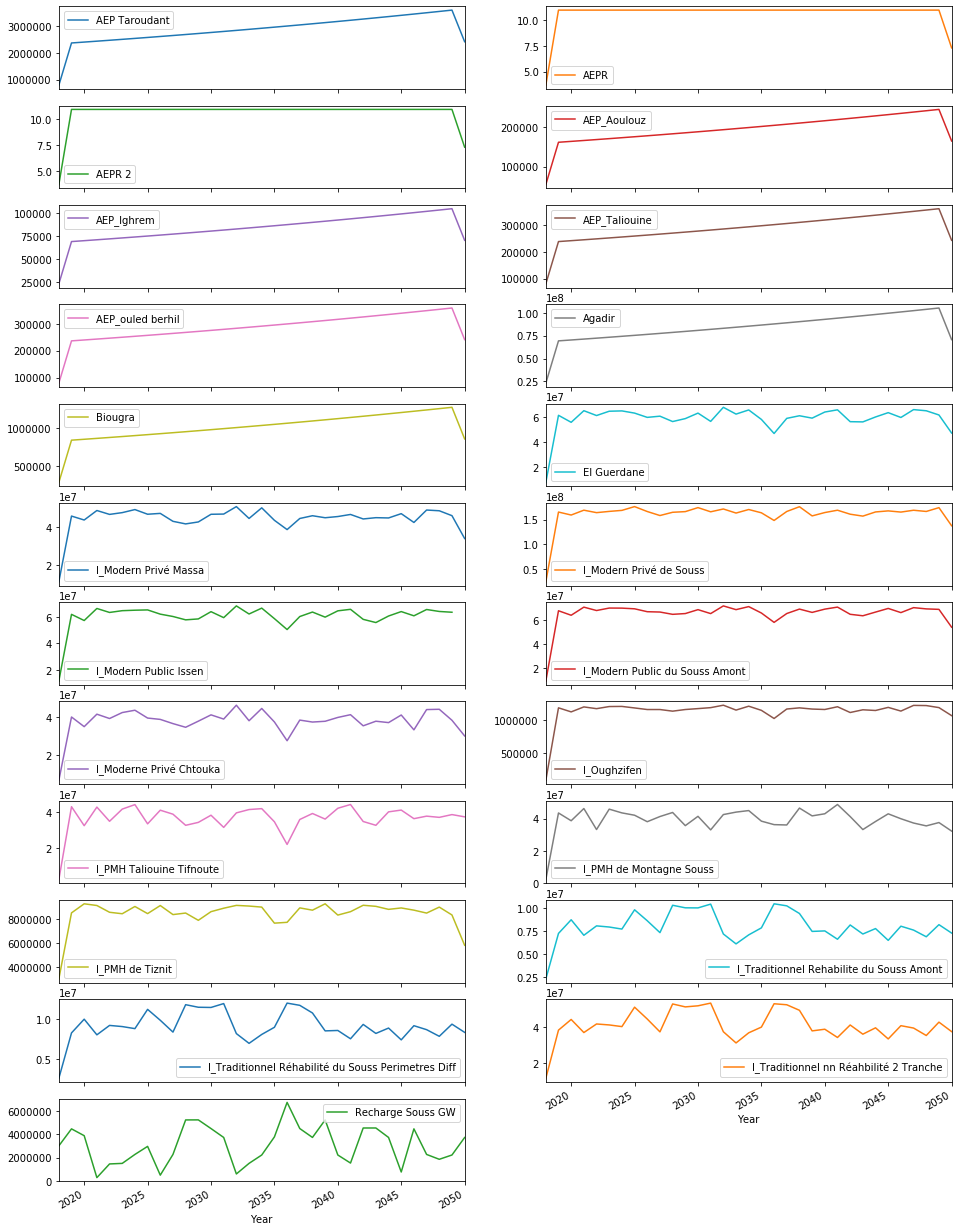

In [117]:
dff = souss_massa.lcoe.reset_index().dropna().pivot('Year','Demand point','water demand')
amount = dff.columns.shape[0] + 1
dff.plot(subplots=True,
         layout=(int(amount/2), 2),
         figsize=(16,24),
#          sharey=True
        )

In [118]:
souss_massa.technologies['Solar PV'].lcoe

,Demand point,discounted_costs,discounted_generation,lcoe,year
0,AEP Rural,1.915505e+02,0.000000e+00,NaN,2018
1,AEP Taroudant,1.202768e+06,8.202271e+06,0.146638,2018
2,AEPR,1.958756e+02,3.571350e+01,5.484638,2018
3,AEPR 2,1.994941e+02,6.659849e+01,2.995475,2018
4,AEP_Aoulouz,5.454987e+04,4.228649e+05,0.129001,2018
...,...,...,...,...,...
1249,Recharge Souss GW,1.128358e+06,8.613692e+06,0.130996,2050
1250,Sidi Ifni,1.140000e+01,0.000000e+00,NaN,2050
1251,Tafraout,1.140000e+01,0.000000e+00,NaN,2050
1252,Tiznit,1.140000e+01,0.000000e+00,NaN,2050


In [119]:
df = souss_massa.lcoe.dropna()
df.reset_index().pivot('Year','Demand point','least_cost_technology')

Demand point,AEP Taroudant,AEPR,AEPR 2,AEP_Aoulouz,AEP_Ighrem,AEP_Taliouine,AEP_ouled berhil,Agadir,Biougra,El Guerdane,...,I_Modern Public du Souss Amont,I_Moderne Privé Chtouka,I_Oughzifen,I_PMH Taliouine Tifnoute,I_PMH de Montagne Souss,I_PMH de Tiznit,I_Traditionnel Rehabilite du Souss Amont,I_Traditionnel Réhabilité du Souss Perimetres Diff,I_Traditionnel nn Réahbilité 2 Tranche,Recharge Souss GW
Year,,,,,,,,,,,,,,,,,,,,,
2018,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Grid pump,...,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Solar PV,Grid pump,Grid pump,Grid pump,Grid pump
2019,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Grid pump,...,Grid pump,Grid pump,Solar PV,Grid pump,Diesel set,Solar PV,Grid pump,Grid pump,Grid pump,Grid pump
2020,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Grid pump,...,Grid pump,Grid pump,Solar PV,Grid pump,Diesel set,Solar PV,Grid pump,Grid pump,Grid pump,Grid pump
2021,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Grid pump,...,Grid pump,Grid pump,Diesel set,Grid pump,Diesel set,Solar PV,Grid pump,Grid pump,Grid pump,Grid pump
2022,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Grid pump,...,Grid pump,Grid pump,Diesel set,Grid pump,Grid pump,Solar PV,Grid pump,Grid pump,Grid pump,Grid pump
2023,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Grid pump,...,Grid pump,Grid pump,Diesel set,Grid pump,Diesel set,Solar PV,Grid pump,Grid pump,Grid pump,Grid pump
2024,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Grid pump,...,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Solar PV,Grid pump,Grid pump,Grid pump,Grid pump
2025,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Grid pump,...,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Solar PV,Grid pump,Grid pump,Grid pump,Grid pump
2026,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Grid pump,...,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Solar PV,Grid pump,Grid pump,Grid pump,Grid pump
